# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [4]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [28]:
# Use this space for any additional import statements you need
import sqlite3

In [76]:
# Place any addtional functions or constants you need here. 
#a function that combines the elements of a series containing tokens into one list.
def combine_tokens(tokens):
    out = []
    for token_list in tokens:
        out = out + token_list
    return out

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
#first - we want to make sure that any stop words are also counted when we remove punctuation and grammar.
for i in sw:
    unpunctsw = re.sub('[^a-zA-Z]','',i)
    if unpunctsw != i:
        sw.append(unpunctsw)
        
#custom addition to remove words with no value that the sw library misses.
sw.append('im')
sw.append('ill')
        
# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
# we have to slightly modify our descriptive stats function to be able to take in an entire PD series rather than an individual
# list of tokens row-by-row.
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    tokens_combined = combine_tokens(tokens)
    
    num_tokens = len(tokens_combined)
    
    #Coercion to the set type gives us unique tokens.
    num_unique_tokens = len(set(tokens_combined))
    
    #there are many ways to calculate diversity, we can use TTR - which is the ratio of unique types to total tokens,
    # or the type-token-ratio, which is calculated from dividing the unique tokens by the total number of tokens.
    lexical_diversity = (num_unique_tokens / num_tokens)
    
    #this can be done by getting the length of each token passed to our function.
    num_characters = sum([len(t) for t in tokens_combined])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        # we can accomplish this by creating a dataframe and turning it into a series.
        n = pd.DataFrame(tokens_combined,columns=['token'])\
            .value_counts()\
            .sort_values(ascending=False)
        print('Five most common tokens:')
        print(n.head(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [t for t in tokens if t not in sw and t != '']
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return(re.split(whitespace_pattern, text))

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [77]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/fkrasovsky/OneDrive - Allvue Systems/Documents/usd/msads-509/Module-1-Scraping-APIs-and Research Questions/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'smashmouth':'smashmouth_followers_data.tsv',
                'wallows':'wallowsmusic_followers_data.tsv'}

In [78]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['smashmouth'],
                           sep="\t")

twitter_data['artist'] = "smashmouth"

In [79]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['wallows'],
                             sep="\t")
twitter_data_2['artist'] = "wallows"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [80]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,JoeyHui4,Joey Hui,953379610410053632,Why do you wanna know?,18,225,I'm whatever SHHS'21 Not on Twitter much..,smashmouth
1,NnelyYnnel,NNELY? YNNEL?,1496696053567000578,NaN,0,15,NaN,smashmouth
2,o_3_k_,3k 🕊️ 🌞,1036063961878282240,"Premiere Theater (HE,HIM)",572,2484,17 | i game occasionally | matching with @batb...,smashmouth
3,Richie_HyenaUK,Richie_HyeanaUK23,1518179116998086656,United Kingdom,58,519,22 He/Him Spotted Hyena British Autistic I lik...,smashmouth
4,ItsBenjaninja,Benjaninja,1121602507216576512,NaN,243,529,26 • Guy who games • BotW glitch enthusiast • ...,smashmouth


In [81]:
# read in the lyrics here - we can do this by using a SQLite file we generated earlier in this class.
con = sqlite3.connect('lyrics.db')
lyrics_data = pd.read_sql("select * from posts", con)
con.close()
lyrics_data.head()

,artist,song_name,text
0,smash mouth,105\n,\n \n \n \n Why the hell are we waitin' in lin...
1,smash mouth,2000 Miles\n,\n \n \n \n He's gone 2000 miles\n It's very f...
2,smash mouth,All Star\n,\n \n \n \n Somebody once told me the world is...
3,smash mouth,Always Gets Her Way\n,\n \n \n \n I know she likes her magazines\n \...
4,smash mouth,Beautiful Bomb\n,\n \n \n \n Your asteroids bounce off her like...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [82]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["text"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [83]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [84]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3103,smashmouth,Navy Veteran - SAG Actor 📺 Union Member👊 - Aut...,"[navy, veteran, sag, actor, 📺, union, member👊,..."
20876,wallows,🐇,[🐇]
33852,smashmouth,"NSFW 🔞 A 15 foot tall, 22 year old alien boi t...","[nsfw, 🔞, 15, foot, tall, 22, year, old, alien..."
15819,smashmouth,❤️ Deep Thoughts ❤️ Deep State ❤️@creaturehunt...,"[❤️, deep, thoughts, ❤️, deep, state, ❤️creatu..."
13140,wallows,✨They/she/xe/xem✨ supporter of ginger brave sl...,"[✨theyshexexem✨, supporter, ginger, brave, sla..."
24986,wallows,I have no idea 🍄✨,"[idea, 🍄✨]"
56165,wallows,i think im losing it 🌙🥝🍓🍉🍒🍋,"[think, losing, 🌙🥝🍓🍉🍒🍋]"
15363,wallows,Serial TV watcher; Freelance Illustrator; Hibe...,"[serial, tv, watcher, freelance, illustrator, ..."
24211,smashmouth,any pronouns idc 🧸19 y/o🧸 ☼ ♋︎ | ◯ ♒︎ | ↑ ♌︎ 🚀 🐌,"[pronouns, idc, 🧸19, yo🧸, ☼, ♋︎, ◯, ♒︎, ↑, ♌︎,..."
25687,wallows,💜ARMY 💜,"[💜army, 💜]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Index 49738 displays a series of emojis that are distinct from another, but are not tokenized separately. we may benefit from logic that separates characters by something other than whitespace if they happen to be emojis.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [122]:
#divide up by artist
lyrics_smash_mouth = lyrics_data.query("artist=='smash mouth'")['tokens']
lyrics_wallows = lyrics_data.query("artist=='wallows'")['tokens']
twitter_smash_mouth = twitter_data.query("artist=='smashmouth'")['tokens']
twitter_wallows = twitter_data.query("artist=='wallows'")['tokens']

In [86]:
# your code here
descriptive_stats(lyrics_smash_mouth)

There are 11572 tokens in the data.
There are 2500 unique tokens in the data.
There are 57629 characters in the data.
The lexical diversity is 0.216 in the data.
Five most common tokens:
token    
get          174
oh           132
know         127
christmas    122
got          122
dtype: int64


[11572, 2500, 0.21603871413757345, 57629]

In [87]:
descriptive_stats(lyrics_wallows)

There are 5250 tokens in the data.
There are 1074 unique tokens in the data.
There are 25978 characters in the data.
The lexical diversity is 0.205 in the data.
Five most common tokens:
token
know     131
like      83
get       80
need      77
time      73
dtype: int64


[5250, 1074, 0.20457142857142857, 25978]

Q: what observations do you make about these data? 

A: Both lyrics datasets commonly use words with little informative value - get, oh, know, got, etc. 
we also observe that Smash Mouth seems to write a lot of christmas music. Many high-frequency words are stop words or filler words, and we might benefit from using TFIDF to remove them.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


### <div style='color:SlateBlue'> In order to execute the above directions, we need one function that does the following:</div>

<div style='color:SlateBlue'>
    <ol>
        <li>Combines all the tokens in a series into one list.</li>
        <li>Gets the value count for each unique token.</li>
    </ol><br>
    <p>We also need a function that:</p>
    <ol>
        <li>Gets the frequency of a term across all four corpora.</li>
        <li>Calculates the ratio of times a term appears in a corpora relative to appearances in other corpora.</li>
    </ol>
</div>

In [118]:
#accepts a pandas series object of tokens and returns a dictionary
def get_frequency(tokensObj,count_name = 'count'):
    #convert into a list.
    tokens_count = Counter(combine_tokens(tokensObj))
    count_df = pd.DataFrame.from_dict(tokens_count, orient='index').reset_index()
    return(count_df.rename(columns={'index':'token',0:count_name}))

In [125]:
#calculate the frequency of a token for each corpus.
wallows_freq_lyrics     =get_frequency(lyrics_wallows,'wallows_lyrics')
wallows_freq_twitter    =get_frequency(twitter_wallows,'wallows_twitter')
smashmouth_freq_lyrics  =get_frequency(lyrics_smash_mouth,'smashmouth_lyrics')
smashmouth_freq_twitter =get_frequency(twitter_smash_mouth,'smashmouth_twitter')

Now, we can move on to combining all four counts into one dataframe - we do not lose the number of times a term appears in each document because we have named each column in a way that can be traced back to its source.

In [140]:
#combine all four corpora into one dataframe, with a column for the frequency of a term from each corpus.
all_tokens = wallows_freq_lyrics\
    .merge(smashmouth_freq_lyrics,how='outer',on='token')\
    .merge(wallows_freq_twitter,how='outer',on='token')\
    .merge(smashmouth_freq_twitter,how='outer',on='token')

In [142]:
#free up kernel space
del wallows_freq_lyrics    
del wallows_freq_twitter  
del smashmouth_freq_lyrics
del smashmouth_freq_twitter

Next, we can get a sum of the total number of times a term shows up on all four corpora. We can also use this to filter out any terms that do not satisfy the criteria of showing up at least n times. In this case, we will use n = 10.

In [159]:
#get a frequency of each term across all four corpora
freq_cols = [x for x in list(all_tokens.columns) if x!='token']
all_tokens['total_freq'] = all_tokens[freq_cols].sum(axis=1)
all_tokens.head()

,token,wallows_lyrics,smashmouth_lyrics,wallows_twitter,smashmouth_twitter,total_freq
0,seventeen,2.0,NaN,24.0,2.0,28.0
1,oh,50.0,132.0,126.0,194.0,502.0
2,girls,2.0,1.0,74.0,88.0,165.0
3,songs,1.0,3.0,44.0,54.0,102.0
4,always,16.0,17.0,251.0,435.0,719.0


In [160]:
#filter out by frequency
filtered_tokens = all_tokens.query('total_freq>=10')
filtered_tokens.head()

,token,wallows_lyrics,smashmouth_lyrics,wallows_twitter,smashmouth_twitter,total_freq
0,seventeen,2.0,NaN,24.0,2.0,28.0
1,oh,50.0,132.0,126.0,194.0,502.0
2,girls,2.0,1.0,74.0,88.0,165.0
3,songs,1.0,3.0,44.0,54.0,102.0
4,always,16.0,17.0,251.0,435.0,719.0


### Next, we need to calculate the ratio at which a term appears in one corpora versus all other corpora.
We can get this measure by iterating over each of our four frequency columns and dividing the frequency in one corpus by the appearance in all corpora except the one currently being evaluated. We can make a shortcut here and take the total freq, subtract our current value, and use it as a denominator. or, if you prefer:
<br>
$$ f(i) = \frac {N(i)}{\sum_j(N(j))}  = \frac{N(i)}{N-N(i)}$$

In [168]:
for i in freq_cols:
    this_ratio = i+'_ratio'
    filtered_tokens[this_ratio] = filtered_tokens[i] / (filtered_tokens['total_freq'] - filtered_tokens[i])
    
filtered_tokens.head()

C:\Users\fkrasovsky\AppData\Local\Temp\ipykernel_23912\4152147311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tokens[this_ratio] = filtered_tokens[i] / (filtered_tokens['total_freq'] - filtered_tokens[i])


,token,wallows_lyrics,smashmouth_lyrics,wallows_twitter,smashmouth_twitter,total_freq,wallows_lyrics_ratio,smashmouth_lyrics_ratio,wallows_twitter_ratio,smashmouth_twitter_ratio
0,seventeen,2.0,NaN,24.0,2.0,28.0,0.076923,NaN,6.000000,0.076923
1,oh,50.0,132.0,126.0,194.0,502.0,0.110619,0.356757,0.335106,0.629870
2,girls,2.0,1.0,74.0,88.0,165.0,0.012270,0.006098,0.813187,1.142857
3,songs,1.0,3.0,44.0,54.0,102.0,0.009901,0.030303,0.758621,1.125000
4,always,16.0,17.0,251.0,435.0,719.0,0.022760,0.024217,0.536325,1.531690


### Finally, we can get a sense of the "top" tokens in each corpus by sorting our dataframe with each column and getting the top 10 results. This operation will happen four times.

In [173]:
for i in freq_cols:
    print('TOP TEN TOKENS FOR: ' + i)
    sort_by_col = i +'_ratio'
    print(filtered_tokens.sort_values(by=sort_by_col,ascending=False)['token'].head(10))
    print('------------------')

TOP TEN TOKENS FOR: wallows_lyrics
704      pulling
18         1980s
830         woah
885    hairstyle
719      explain
883       fucker
881      scrawny
686      wasting
623       relate
791    hollywood
Name: token, dtype: object
------------------
TOP TEN TOKENS FOR: smashmouth_lyrics
2438    sheã¢â€â™s
1227        chorus
1280         claus
2357        walkin
1271     christmas
1771          whoa
522          comin
889         theyll
1784        hangin
1672       flippin
Name: token, dtype: object
------------------
TOP TEN TOKENS FOR: wallows_twitter
4011       ⠀⠀⠀⠀⠀
9039           𖥻
4300       quase
4286         ⠀⠀⠀
4285     ⠀⠀⠀⠀⠀⠀⠀
31218        mla
4262     o’brien
4259     harry’s
4253      #harry
4249      stunts
Name: token, dtype: object
------------------
TOP TEN TOKENS FOR: smashmouth_twitter
87356            dungeons
61310           communism
60425             economy
60416              fierce
60401                maga
60363           #resister
60353    environmentalist
60

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top ten tokens for smash mouth, again, overwhelmingly seem to be christmas themed. The tokens for wallows lyrics seem to mostly be negatively-sentimented, and even include a swear word, so we can presume that many of their songs might contain explicit language. The #Harry hashtag for the wallows twitter data suggests that many wallows fans might also be followers of Harry Styles, and the smash mouth twitter data seems to have a heavy political presence, with communism, the economy, trump, and the environment making notable appearances.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [175]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [183]:
df = filtered_tokens.set_index('token')
df.head()

,wallows_lyrics,smashmouth_lyrics,wallows_twitter,smashmouth_twitter,total_freq,wallows_lyrics_ratio,smashmouth_lyrics_ratio,wallows_twitter_ratio,smashmouth_twitter_ratio
token,,,,,,,,,
seventeen,2.0,NaN,24.0,2.0,28.0,0.076923,NaN,6.000000,0.076923
oh,50.0,132.0,126.0,194.0,502.0,0.110619,0.356757,0.335106,0.629870
girls,2.0,1.0,74.0,88.0,165.0,0.012270,0.006098,0.813187,1.142857
songs,1.0,3.0,44.0,54.0,102.0,0.009901,0.030303,0.758621,1.125000
always,16.0,17.0,251.0,435.0,719.0,0.022760,0.024217,0.536325,1.531690


## Having updated the index, we can generate a wordcloud for each corpus by iterating over the frequency columns.

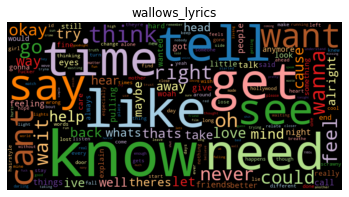

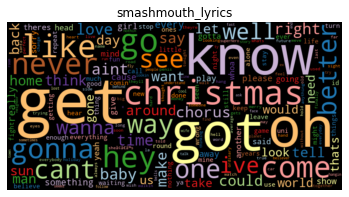

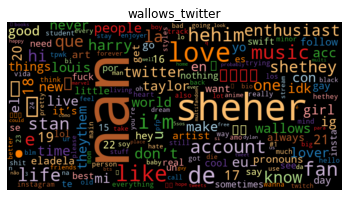

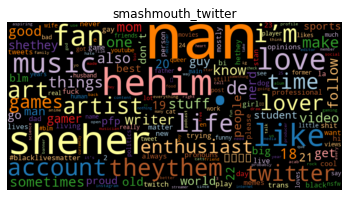

In [190]:
for col in freq_cols:
    wordcloud(df[col],title=col)
    plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Twitter data seems to have a lot of empty descriptions as well as the word love in several variations. Both twitter clouds seem to feature frequent use of pronouns in the user descriptions. The lyrics primarily feature verbs like know and need, but smash mouth separates itself by frequently mentioning christmas.